## Modeling Housing Cost  
### SVM Built from First Principles

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import sys
sys.path.append('..')

from models.svm.svm import SVMRegressor, SVMVisualizer, SVMStatistics


In [2]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'ad_housing','train.csv'))
df_test = pd.read_csv(os.path.join('..', 'data', 'raw', 'ad_housing','test.csv'))


In [ ]:
def preprocess_regression_data(df, target_col, test_size=0.2):
    cols_to_drop = [target_col]
    if 'Id' in df.columns:
        cols_to_drop.append('Id')
    
    X = df.drop(columns=cols_to_drop)
    y = df[target_col]
    
    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Numeric features: {len(numeric_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    print(f"\nNumeric columns: {numeric_features[:5]}...")
    print(f"Categorical columns: {categorical_features[:5]}...")
    
    # Create preprocessing pipelines for numeric and categorical data
    
    # Numeric pipeline: impute with median, then scale
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # median is more robust to outliers
        ('scaler', StandardScaler())
    ])
    
    # Categorical pipeline: impute with most frequent, then one-hot encode
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'  # Drop any columns not specified
    )
    
    # Split the data BEFORE any transformation (avoid data leakage)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Fit preprocessor on training data and transform both train and test
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)  # Only transform, not fit
    
    print(f"\nOriginal feature count: {X.shape[1]}")
    print(f"Transformed feature count: {X_train_transformed.shape[1]}")
    print(f"(Increase due to one-hot encoding)")
    
    # Scale target variable
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
    
    print(f"\nTraining set: {X_train_transformed.shape[0]} samples")
    print(f"Test set: {X_test_transformed.shape[0]} samples")
    
    return (X_train_transformed, X_test_transformed, 
            y_train_scaled, y_test_scaled, 
            preprocessor, scaler_y, 
            numeric_features, categorical_features)

Dataset Shape: (1460, 81)

First few rows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleC

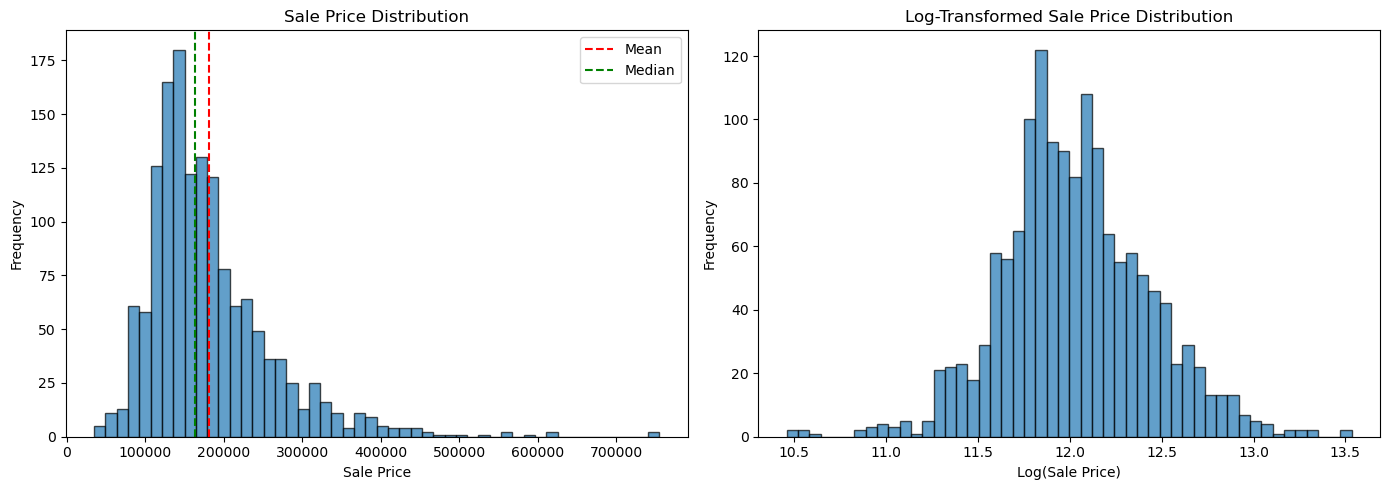

In [4]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print("\nTarget Variable (SalePrice) Statistics:")
print(df['SalePrice'].describe())

print("\nData Types:")
print(df.dtypes.value_counts())

# Visualize target distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].hist(df['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sale Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Sale Price Distribution')
axes[0].axvline(df['SalePrice'].mean(), color='r', linestyle='--', label='Mean')
axes[0].axvline(df['SalePrice'].median(), color='g', linestyle='--', label='Median')
axes[0].legend()

# Log-transformed distribution
axes[1].hist(np.log1p(df['SalePrice']), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Sale Price)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Sale Price Distribution')
plt.tight_layout()
plt.show()

In [5]:
X_train, X_test, y_train, y_test = preprocess_regression_data(
    df, target_col='SalePrice', test_size=0.2
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nTraining target mean: {y_train.mean():.4f}")
print(f"Training target std: {y_train.std():.4f}")

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'RL'